In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/pcosdata'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [62]:
#Importing all the libraries that I use in this project
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [63]:
#Loding data into the kernels 

file_path_with_infertility="/Users/yuktadandekar/Downloads/PCOSdata/PCOS_infertility.csv"
file_path_without_infertility="/Users/yuktadandekar/Downloads/PCOSdata/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

In [64]:
import pandas as pd

# Merging the two files as per patient file no. 
# The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf, PCOS_inf, on='Patient File No.', suffixes=('', '_y'), how='left')

# Dropping the repeated features after merging
data = data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

# Taking a look at the dataset
print(data.head()) 

   Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
0       1                 1           0          28         44.6        152.0   
1       2                 2           0          36         65.0        161.5   
2       3                 3           1          33         68.8        165.0   
3       4                 4           0          37         65.0        148.0   
4       5                 5           0          25         52.0        161.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  ...  \
0  19.300000           15                78                22  ...   
1  24.921163           15                74                20  ...   
2  25.270891           11                72                18  ...   
3  29.674945           13                72                20  ...   
4  20.060954           11                72                18  ...   

   Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0             0 

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [66]:
#Having a look at the data with dtype objects

data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [67]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [68]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values. 
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/1758435866.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/1758435866.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate

In [69]:
# Having a look at some basic statistical details.

data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


In [70]:

data = data[(data["BP _Diastolic (mmHg)"]>20)]
data = data[(data["AMH(ng/mL)"]<40)]
data = data[(data["BP _Systolic (mmHg)"]>20)]
data = data[(data["Endometrium (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["Avg. F size (R) (mm)"]>0)]
data = data[(data["RBS(mg/dl)"]<200)]
data = data[(data["PRG(ng/mL)"]<20)]
data = data[(data["Pulse rate(bpm)"]>20)]
data = data[(data["FSH(mIU/mL)"]<4000)]
data = data[(data["LH(mIU/mL)"]<1500)]
data = data[(data["Cycle(R/I)"]<4.5)]

data.shape

(526, 44)

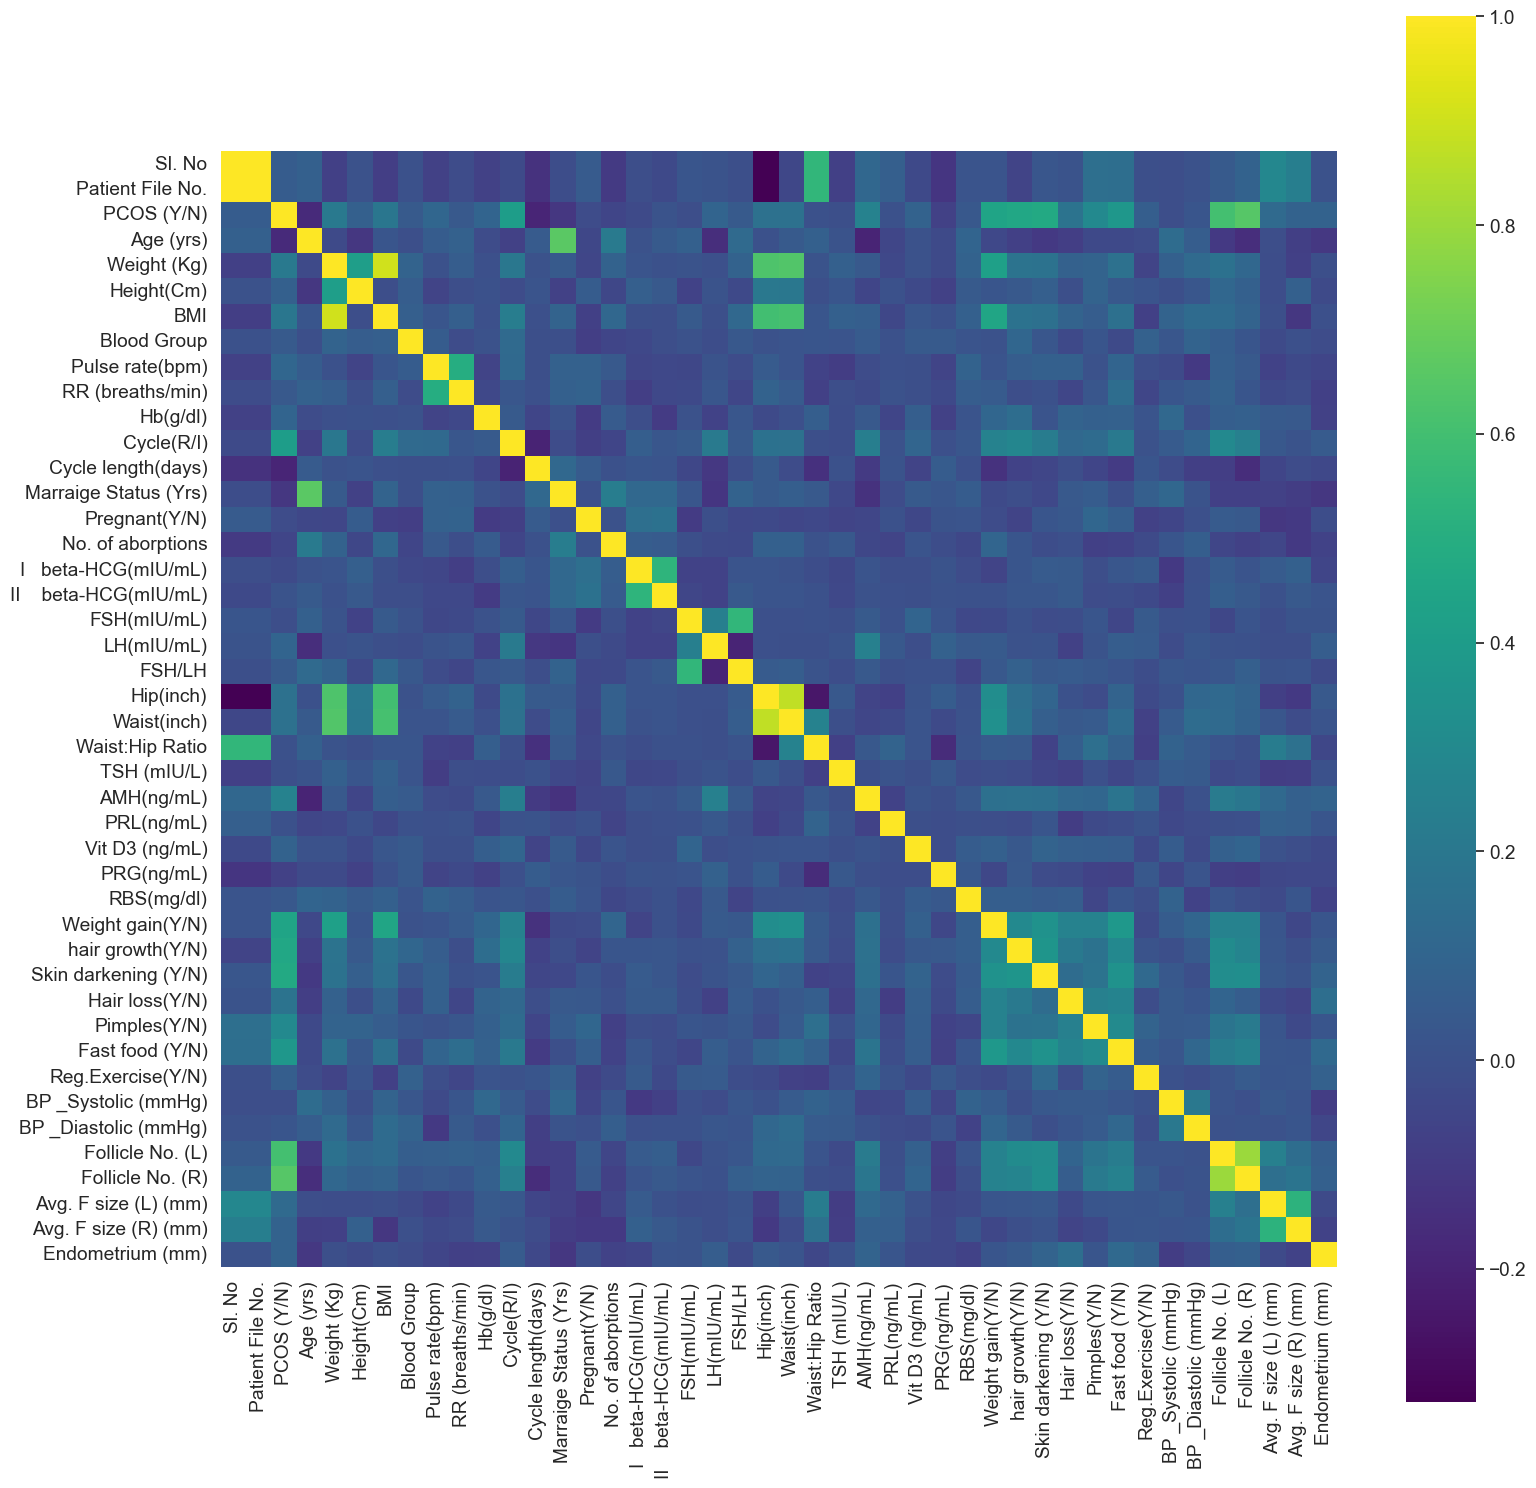

In [71]:
corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="viridis", square=True);

In [72]:
corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.650915
Follicle No. (L)          0.605305
Skin darkening (Y/N)      0.474561
hair growth(Y/N)          0.463557
Weight gain(Y/N)          0.445646
Cycle(R/I)                0.404082
Fast food (Y/N)           0.376877
Pimples(Y/N)              0.295313
AMH(ng/mL)                0.261105
Weight (Kg)               0.210241
BMI                       0.194121
Hair loss(Y/N)            0.176603
Hip(inch)                 0.163335
Waist(inch)               0.160226
Avg. F size (L) (mm)      0.124990
Pulse rate(bpm)           0.102988
LH(mIU/mL)                0.095426
Hb(g/dl)                  0.094481
Vit D3 (ng/mL)            0.086052
Endometrium (mm)          0.085608
Avg. F size (R) (mm)      0.084756
Height(Cm)                0.075431
Reg.Exercise(Y/N)         0.061816
Sl. No                    0.051936
Patient File No.          0.051936
FSH/LH                    0.043591
Blood Group               0.043032
RR (breaths/min)    

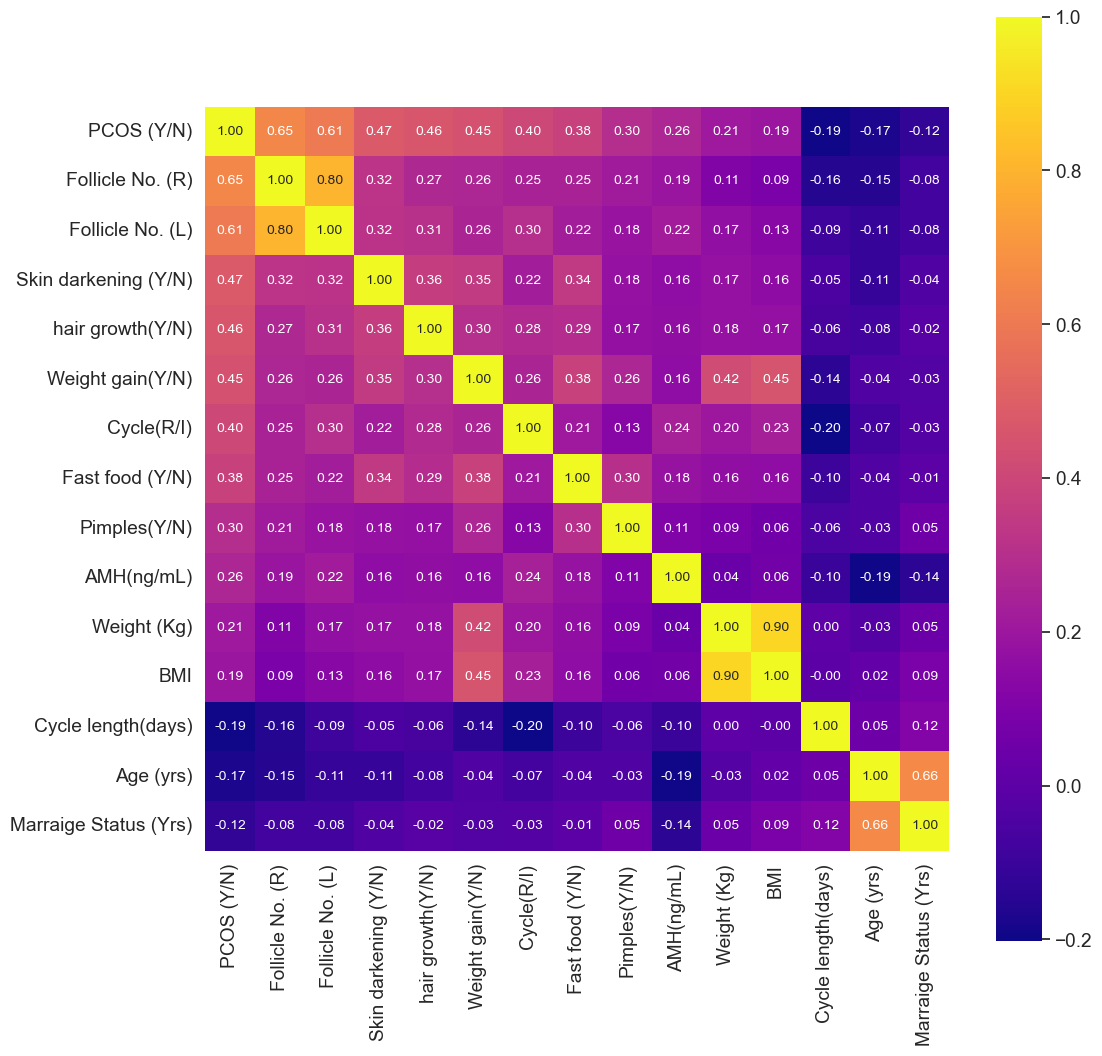

In [73]:
#Having a look at features bearing significant correlation

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index 
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="plasma", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

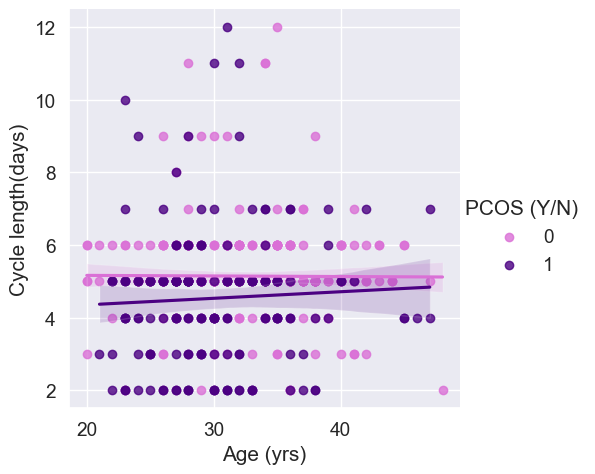

In [74]:
# Length of menstrual phase in PCOS vs normal 
color = ["orchid", "indigo"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

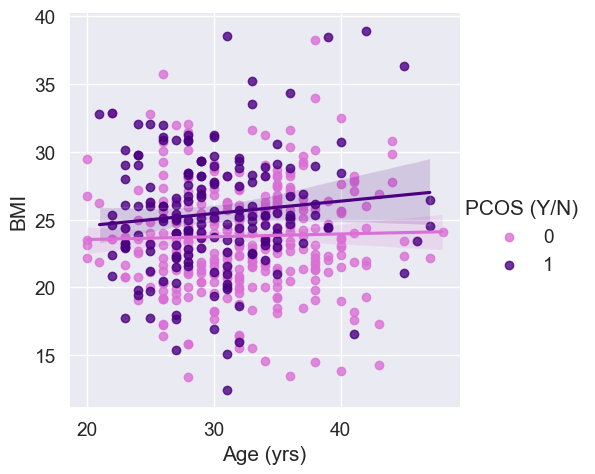

In [75]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

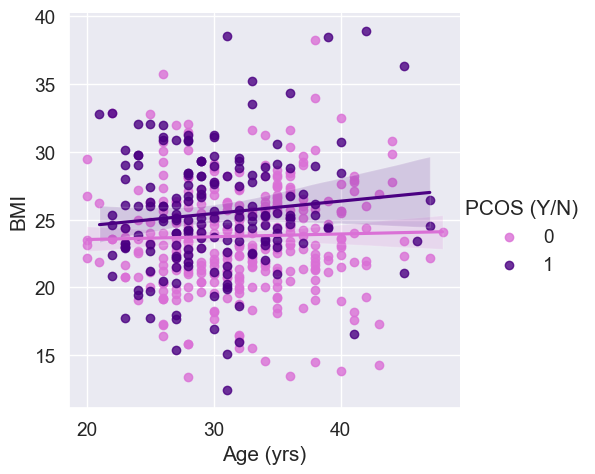

In [76]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

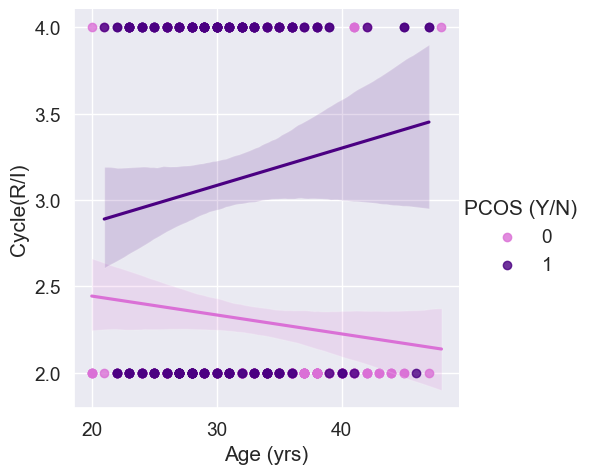

In [77]:
# cycle IR wrt age 
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

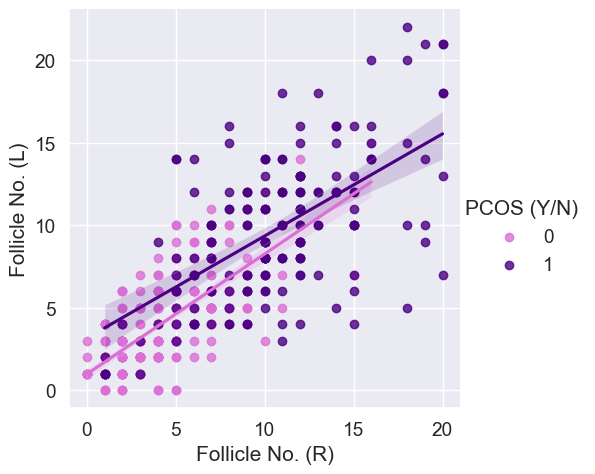

In [78]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/2788341060.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


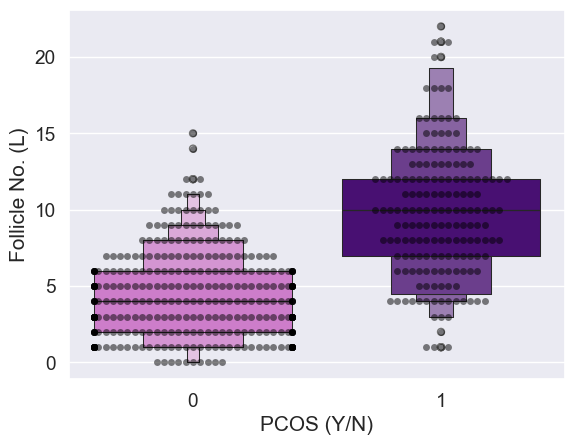

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/2788341060.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


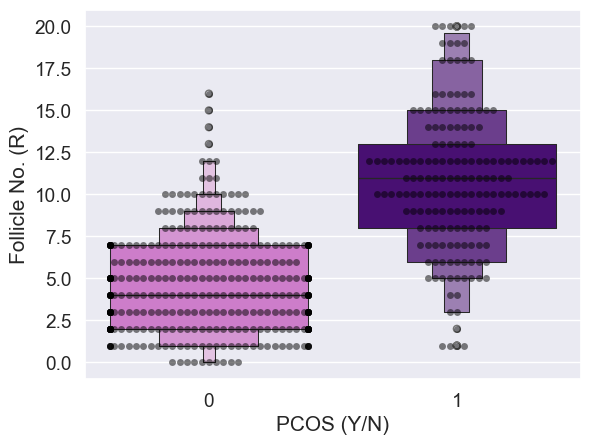

In [79]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


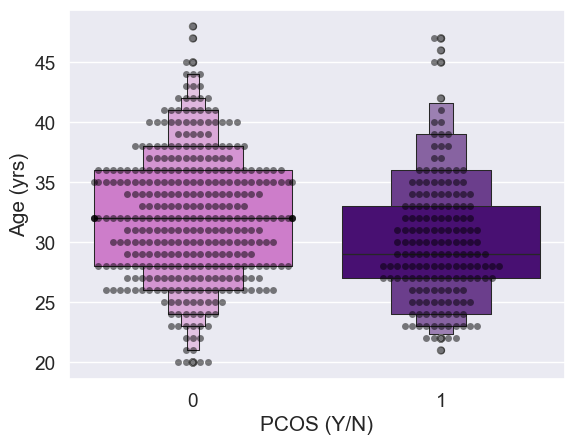

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


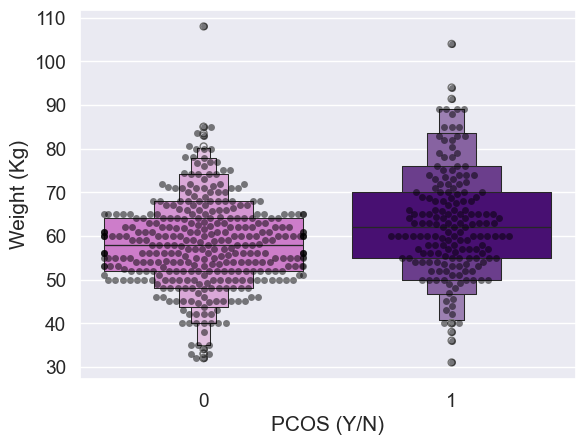

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


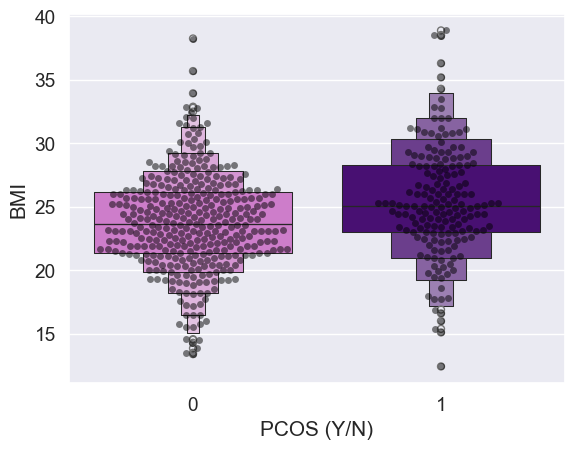

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


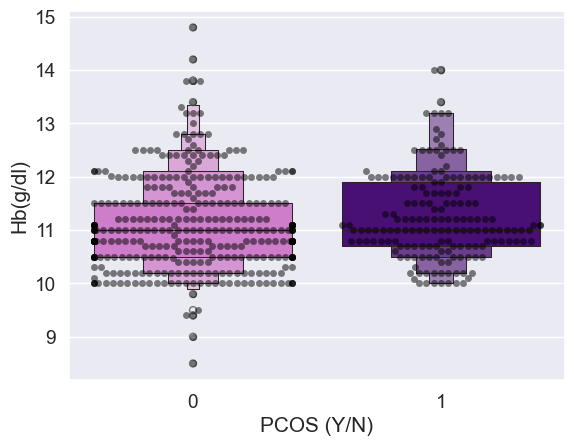

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning

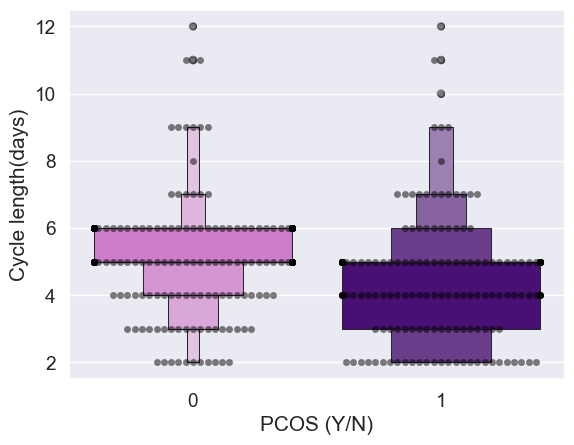

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


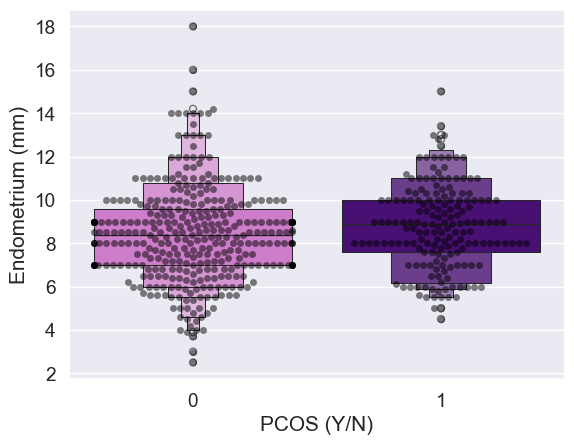

In [80]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

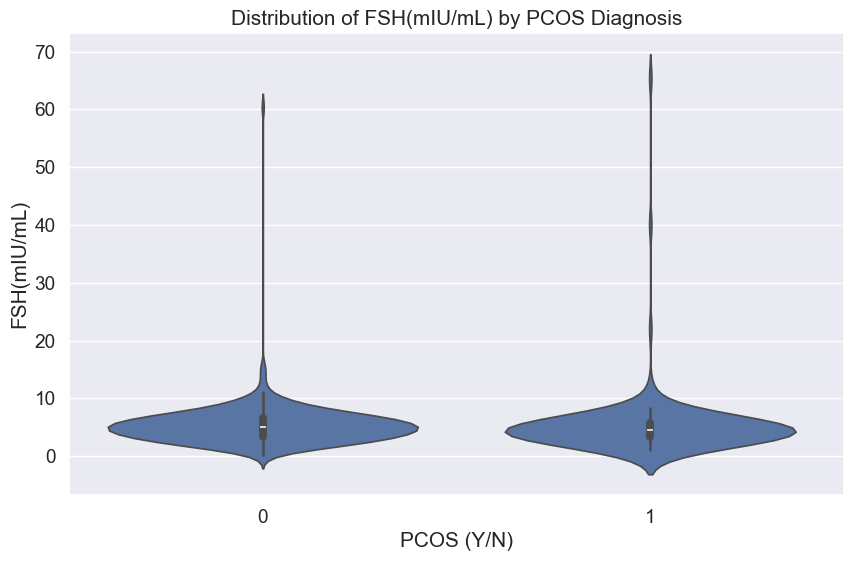

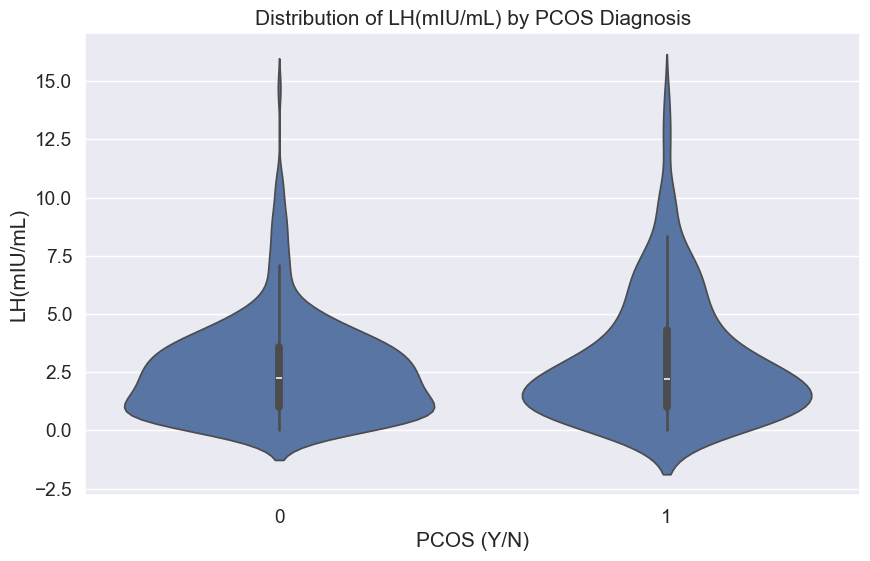

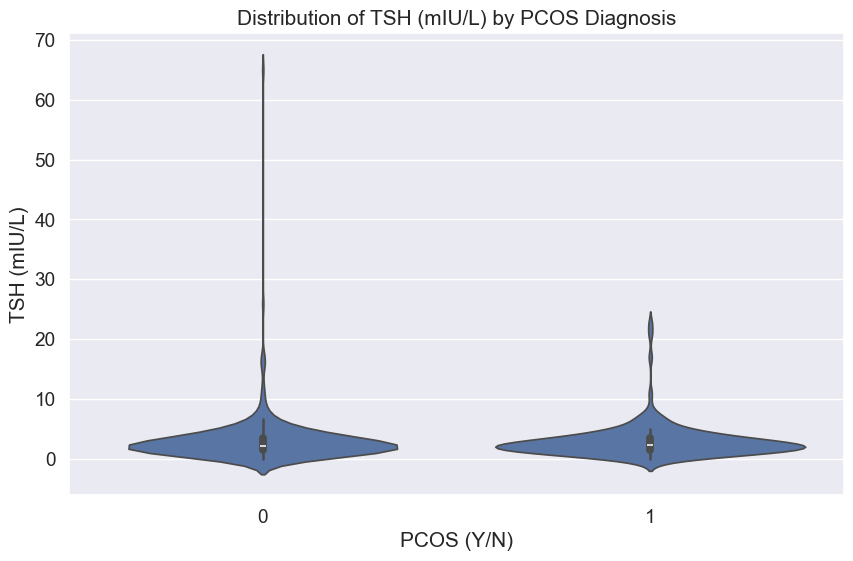

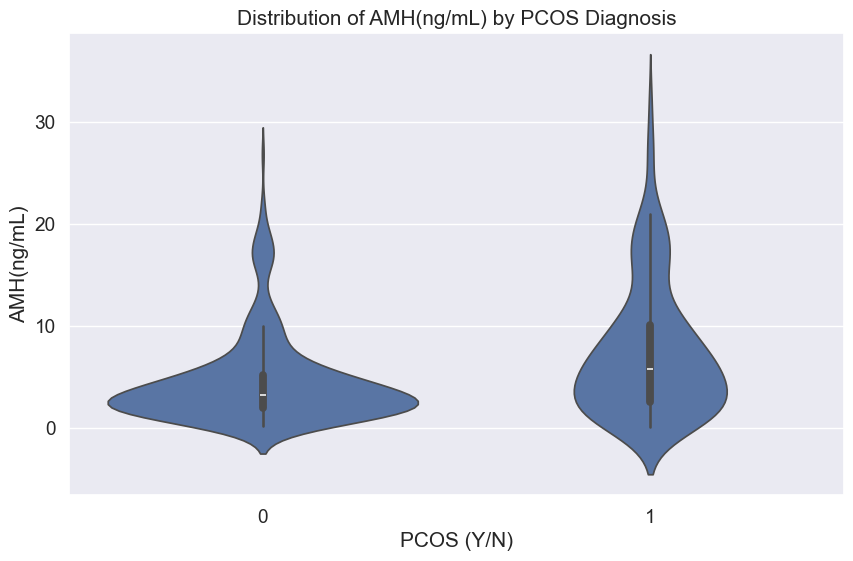

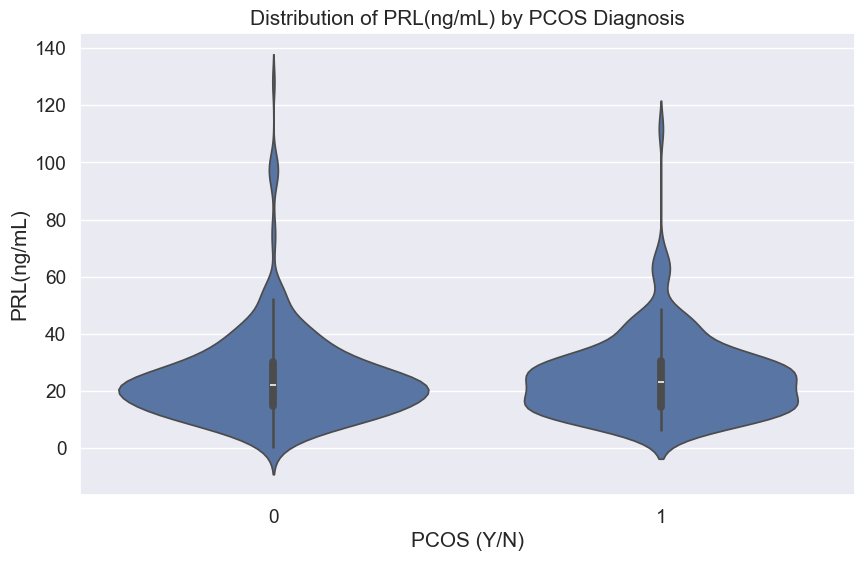

In [81]:
hormones = ["FSH(mIU/mL)", "LH(mIU/mL)", "TSH (mIU/L)", "AMH(ng/mL)", "PRL(ng/mL)"]
for hormone in hormones:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="PCOS (Y/N)", y=hormone, data=data)
    plt.title(f"Distribution of {hormone} by PCOS Diagnosis")
    plt.show()

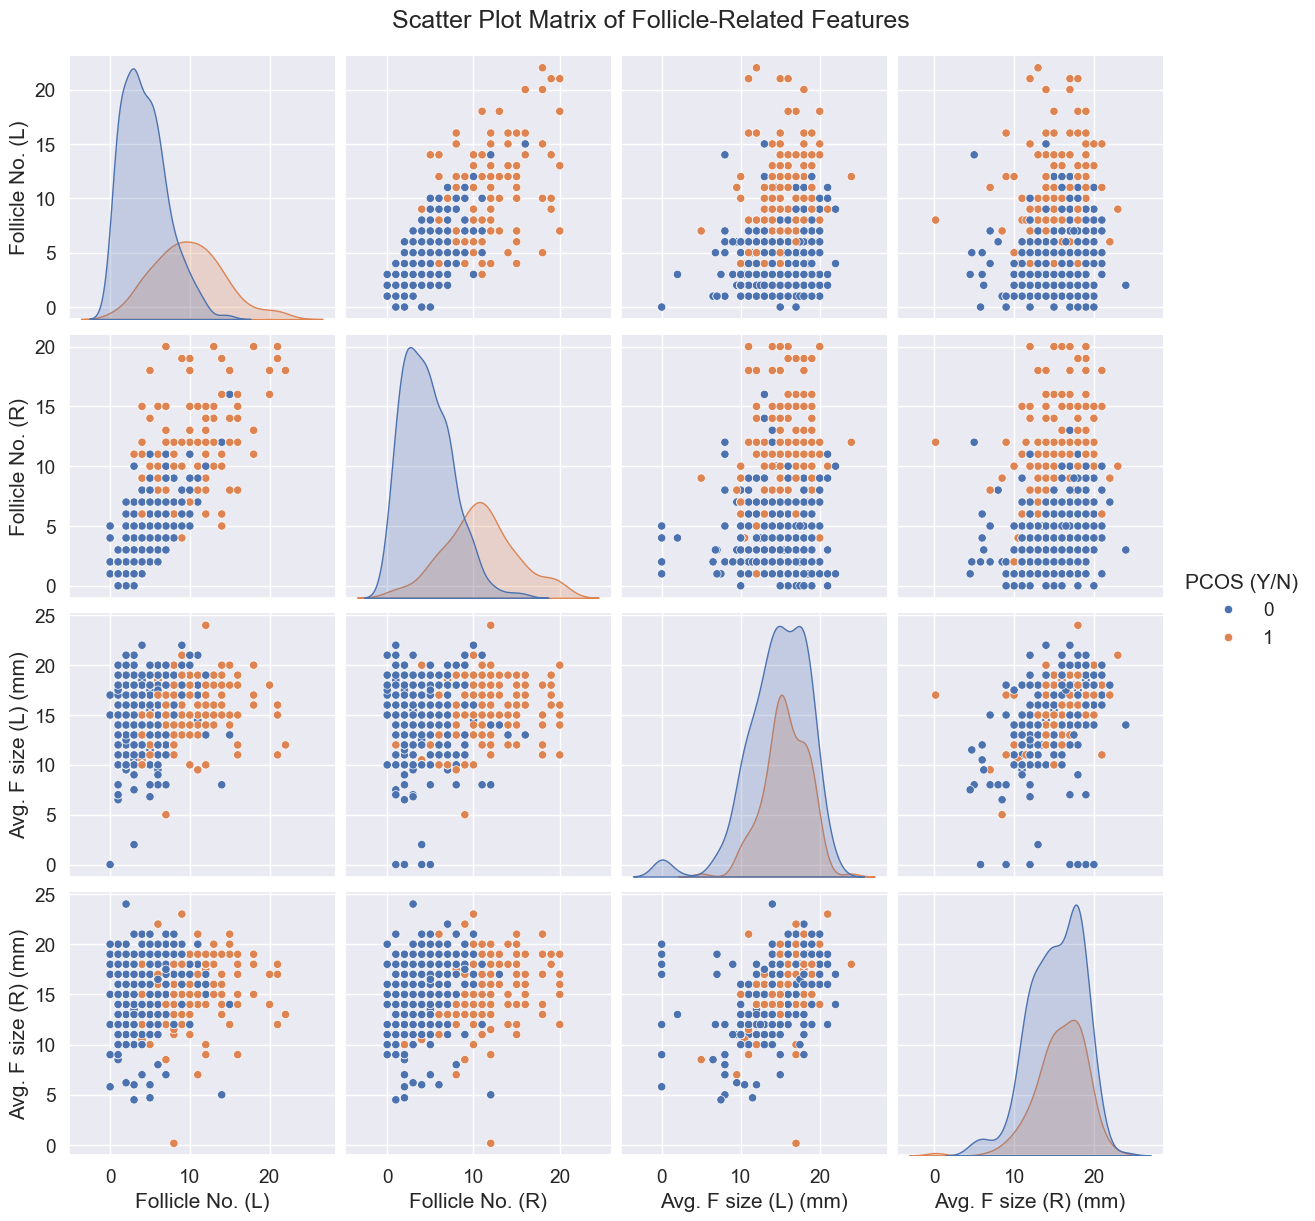

In [82]:
follicle_features = ["Follicle No. (L)", "Follicle No. (R)", "Avg. F size (L) (mm)", "Avg. F size (R) (mm)"]
sns.pairplot(data[follicle_features + ["PCOS (Y/N)"]], hue="PCOS (Y/N)", height=3)
plt.suptitle("Scatter Plot Matrix of Follicle-Related Features", y=1.02)
plt.show()

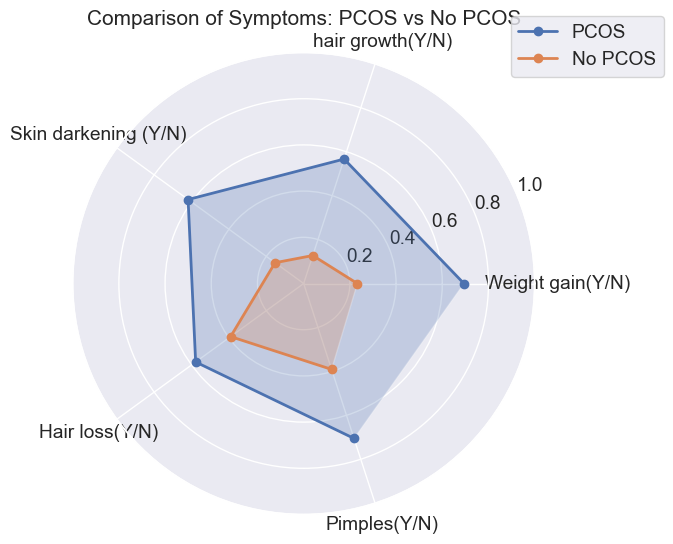

In [83]:
import matplotlib.pyplot as plt
import numpy as np

symptoms = ["Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", "Pimples(Y/N)"]

pcos_yes = data[data["PCOS (Y/N)"] == 1][symptoms].mean()
pcos_no = data[data["PCOS (Y/N)"] == 0][symptoms].mean()

angles = np.linspace(0, 2*np.pi, len(symptoms), endpoint=False)

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='polar'))
ax.plot(angles, pcos_yes, 'o-', linewidth=2, label='PCOS')
ax.fill(angles, pcos_yes, alpha=0.25)
ax.plot(angles, pcos_no, 'o-', linewidth=2, label='No PCOS')
ax.fill(angles, pcos_no, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, symptoms)
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title("Comparison of Symptoms: PCOS vs No PCOS")
plt.show()

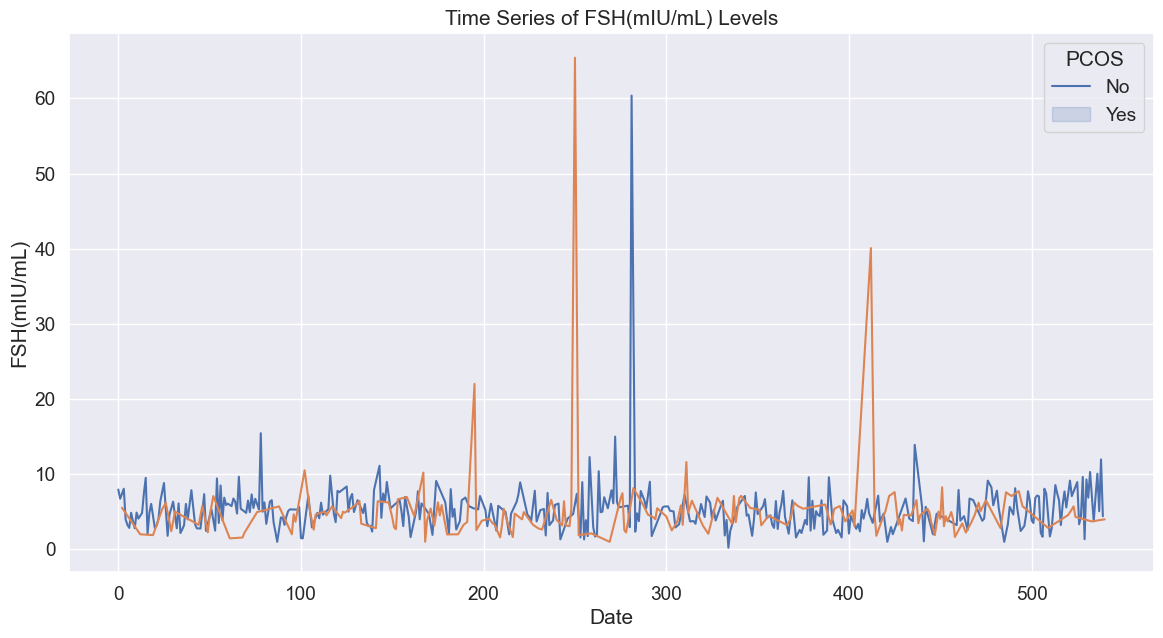

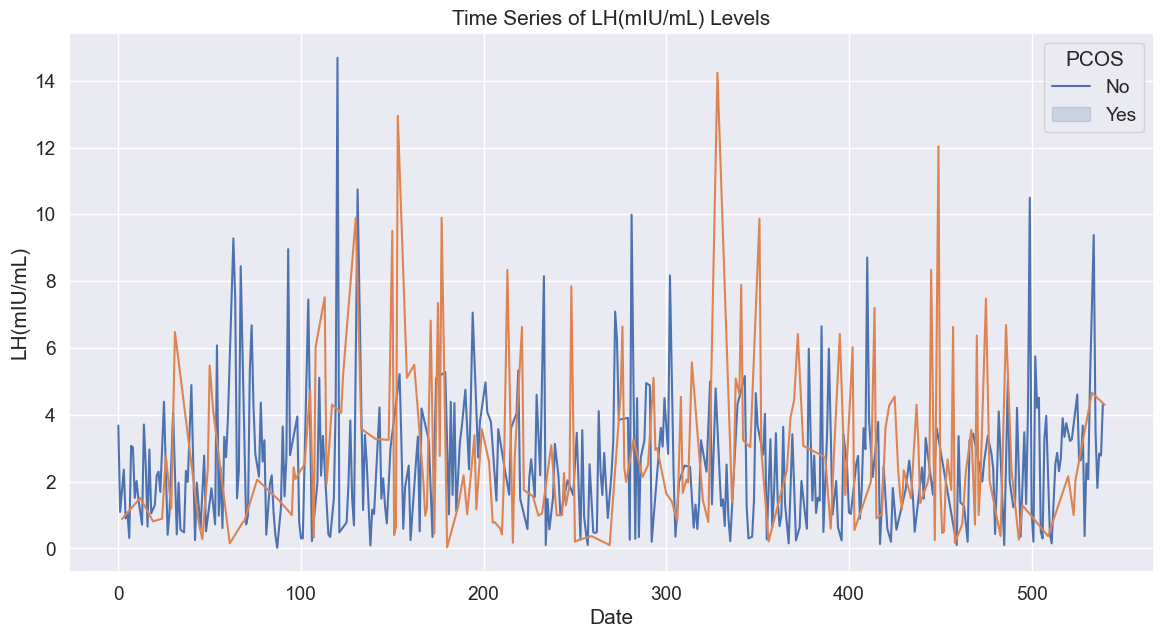

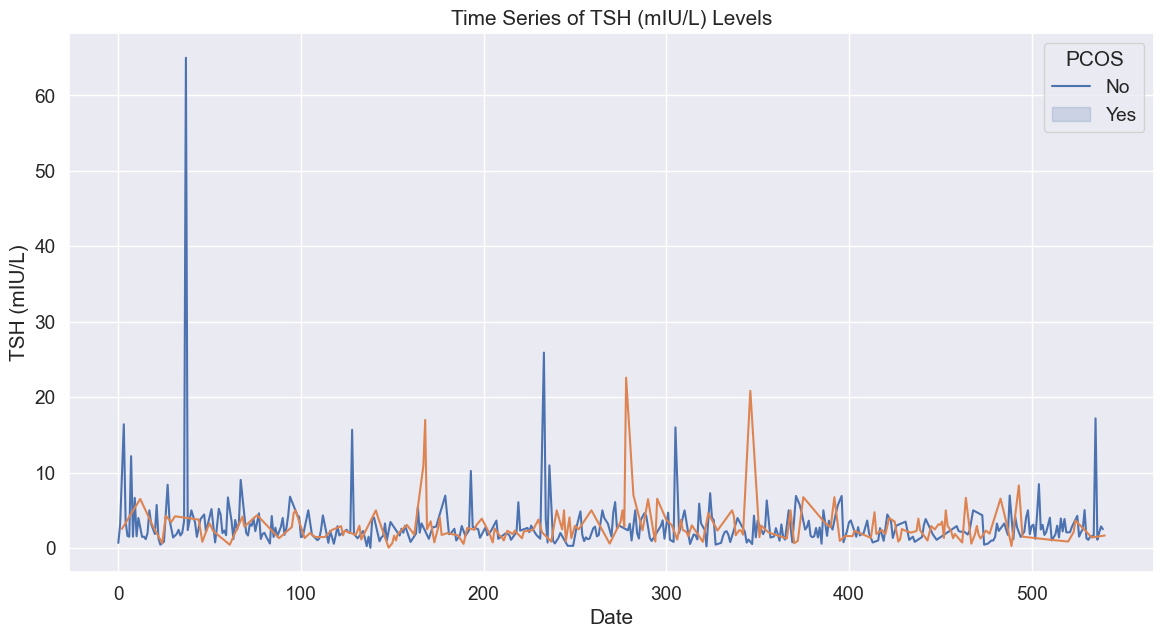

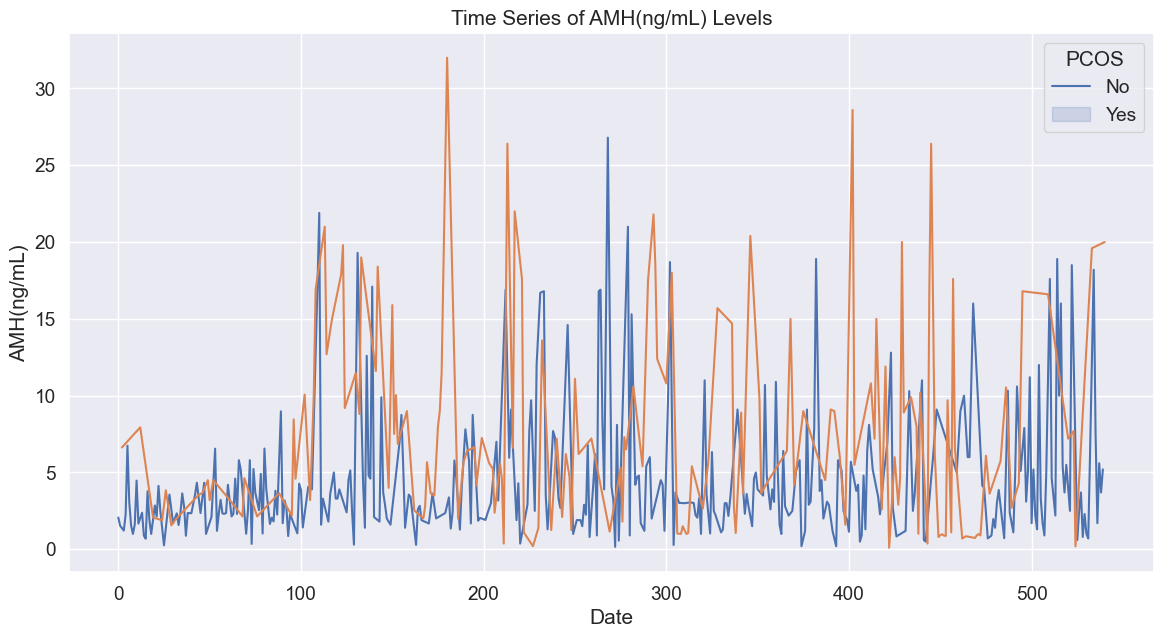

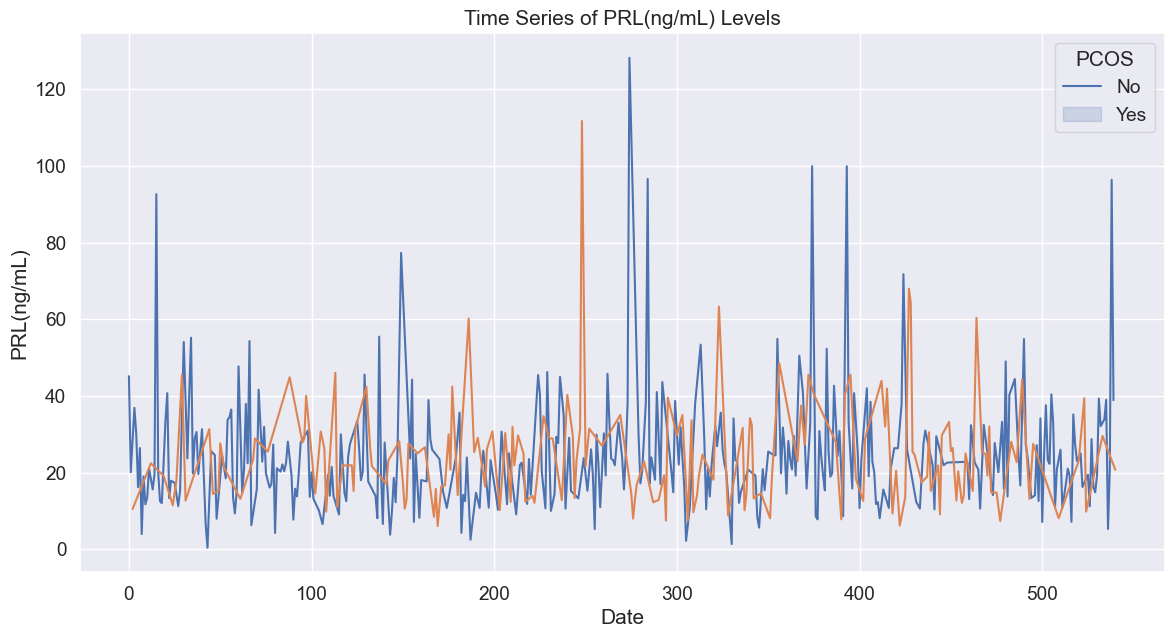

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of hormone levels to plot
hormones = ["FSH(mIU/mL)", "LH(mIU/mL)", "TSH (mIU/L)", "AMH(ng/mL)", "PRL(ng/mL)"]

# Plot time series for each hormone
for hormone in hormones:
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=data, x=data.index, y=hormone, hue="PCOS (Y/N)")
    plt.title(f'Time Series of {hormone} Levels')
    plt.xlabel('Date')
    plt.ylabel(hormone)
    plt.legend(title='PCOS', labels=['No', 'Yes'])
    plt.show()

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


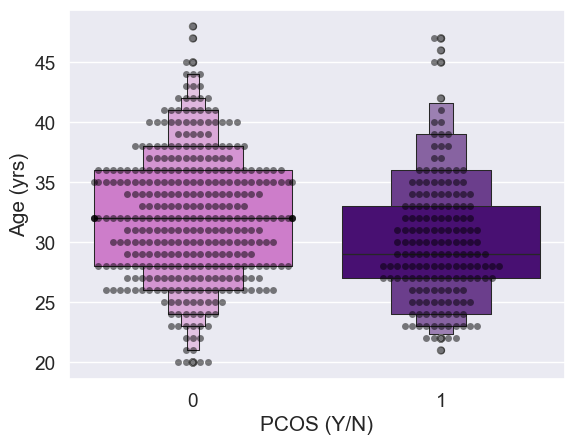

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


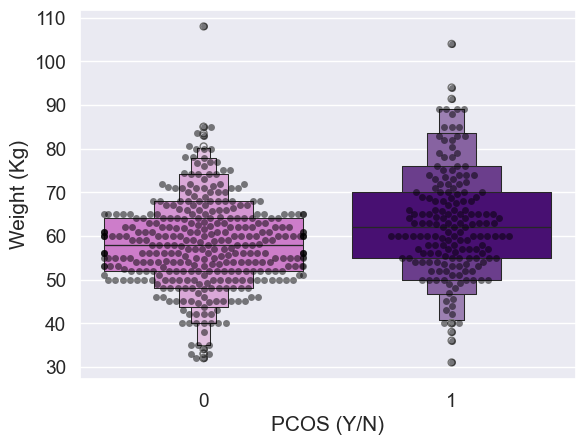

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)


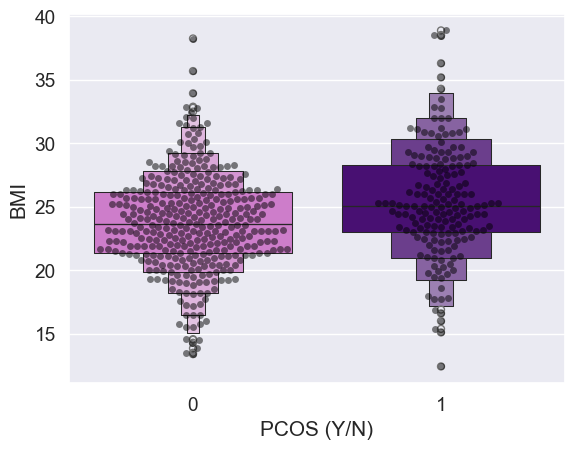

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


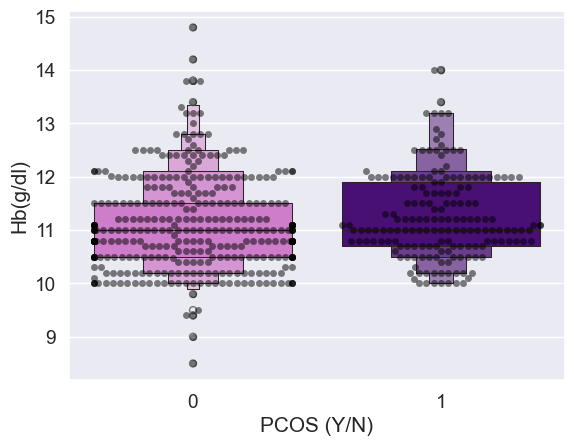

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning

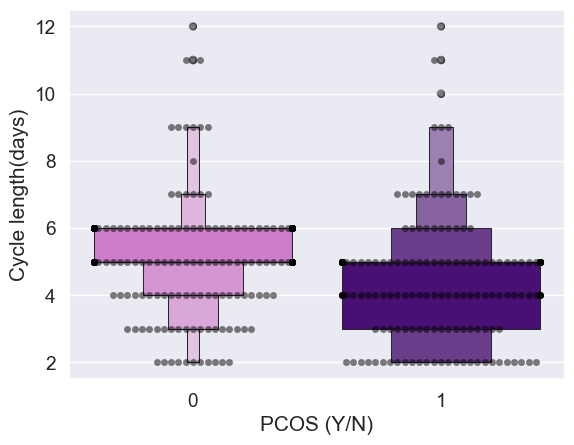

/var/folders/10/5wk91hrj1b193w1kq78h8_tr0000gn/T/ipykernel_99915/215697658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


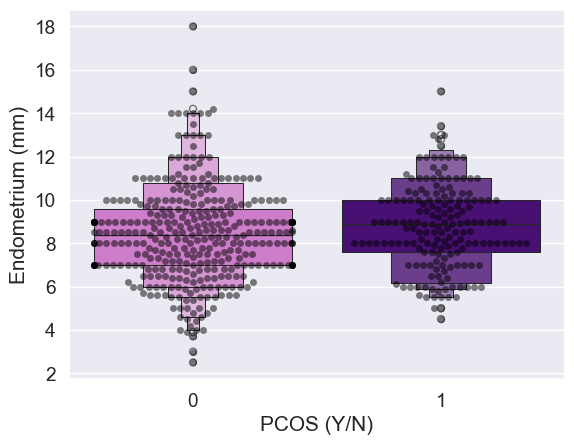

In [85]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

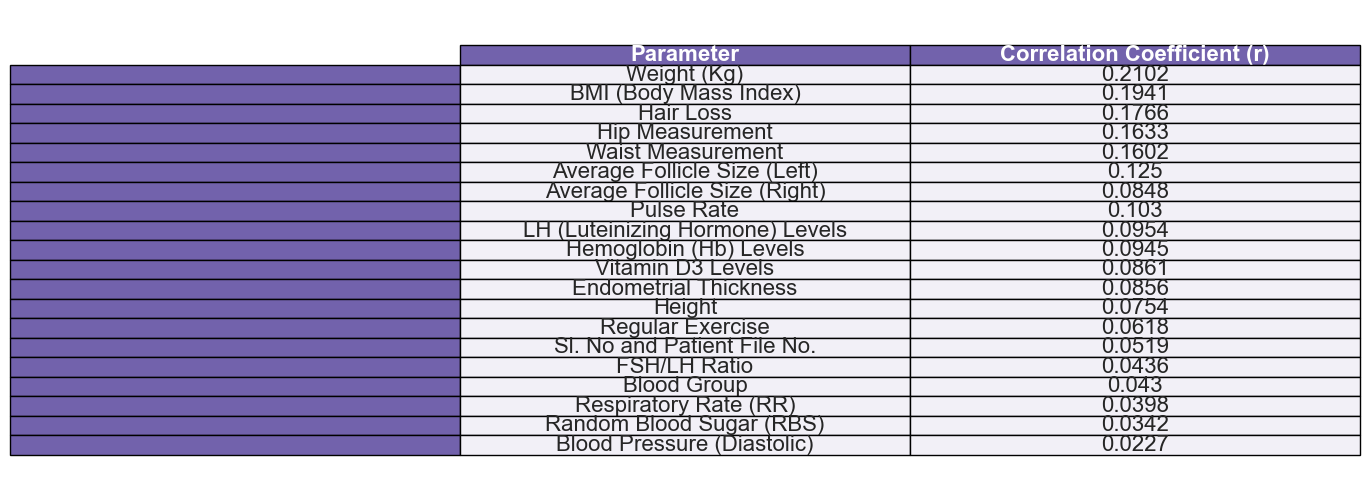

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Data for the table
data = {
    "Parameter": [
        "Weight (Kg)", "BMI (Body Mass Index)", "Hair Loss", "Hip Measurement", "Waist Measurement", 
        "Average Follicle Size (Left)", "Average Follicle Size (Right)", "Pulse Rate", 
        "LH (Luteinizing Hormone) Levels", "Hemoglobin (Hb) Levels", "Vitamin D3 Levels", 
        "Endometrial Thickness", "Height", "Regular Exercise", "Sl. No and Patient File No.", 
        "FSH/LH Ratio", "Blood Group", "Respiratory Rate (RR)", "Random Blood Sugar (RBS)", 
        "Blood Pressure (Diastolic)"
    ],
    "Correlation Coefficient (r)": [
        0.2102, 0.1941, 0.1766, 0.1633, 0.1602, 0.1250, 0.0848, 0.1030, 0.0954, 0.0945, 
        0.0861, 0.0856, 0.0754, 0.0618, 0.0519, 0.0436, 0.0430, 0.0398, 0.0342, 0.0227
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting the table
fig, ax = plt.subplots(figsize=(10, 8))

# Remove axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)  

# Table colors
colors = plt.cm.Purples(np.linspace(0, 1.0, len(df)+1))
cmap = ListedColormap(colors)

# Create table
table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=[cmap(0.7)]*2, rowColours=colors[1:])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1.5, 1.5)
for key, cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor(cmap(0.7))
    else:
        cell.set_facecolor(cmap(0.1))

# Adjust layout
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.3)

# Save the figure
plt.savefig("enhanced_positive_correlations.png")

# Show the table
plt.show()


In [87]:
data['Date'] = pd.to_datetime(data['Date'])

KeyError: 'Date'

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical features to plot
numerical_features = ["Age (yrs)", "Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)", "Endometrium (mm)"]

# Plot histograms
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

KeyError: 'Age (yrs)'

<Figure size 1000x600 with 0 Axes>

In [90]:
# List of categorical features to plot
categorical_features = ["Blood Group", "Cycle(R/I)", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)"]

# Plot bar plots
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=data[feature], hue=data["PCOS (Y/N)"], palette="viridis")
    plt.title(f'{feature} by PCOS Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='PCOS')
    plt.show()

KeyError: 'Blood Group'

<Figure size 1000x600 with 0 Axes>

In [94]:
print(data.columns)


AttributeError: 'dict' object has no attribute 'columns'

In [96]:
data.head()

AttributeError: 'dict' object has no attribute 'head'